## 데이터마이닝 기말과제
한양대학교 전자공학과 2020172607 이진유 <br>
데이터마이닝 <br>
adversarial examples 생성(100장) <br>
제출 기한 : ~2020.06.10까지 <br>


### 데이터 셋

In [1]:
import os
import time
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, losses, metrics
from tqdm import tqdm
import numpy as np

X_test = np.load('data/X_test.npy')
y_test = np.load('data/y_test.npy')

BATCH_SIZE = 2**5 # 배치사이즈
gen_num = 100 # 생성할 이미지 갯수

print(X_test.shape, y_test.shape)

(500, 160, 160, 3) (500,)


### 패키지 버전
- 텐서플로우 2.1.0

In [2]:
print('tf',tf.__version__)

tf 2.1.0


In [3]:
class Model(models.Model):
    def __init__(self, base_model):
        super(Model, self).__init__()
        self.base_model = base_model
        self.top_layer = models.Sequential([
            layers.Dense(10),
            layers.Activation(tf.nn.softmax),
        ])

    def call(self, inputs, training=False):
        x = self.base_model(inputs, training=training)
        x = layers.Flatten()(x)
        outputs = self.top_layer(x, training=training)
        return outputs

### 모델 사전 학습

In [4]:
def build_model(weights, arg_scope='inception'):
    if arg_scope == 'inception':
        base_model = tf.keras.applications.InceptionV3(input_shape=[160, 160, 3], include_top=False,
                                                       weights='imagenet')
    elif arg_scope == 'inception_res':
        base_model = tf.keras.applications.InceptionResNetV2(input_shape=[160, 160, 3], include_top=False,
                                                       weights='imagenet')
    elif arg_scope == 'resnet':
        base_model = tf.keras.applications.ResNet152V2(input_shape=[160, 160, 3], include_top=False,
                                                             weights='imagenet')
    elif arg_scope == 'mobile':
        base_model = tf.keras.applications.MobileNetV2(input_shape=[160, 160, 3], include_top=False,
                                                       weights='imagenet')

    model = Model(base_model)
    model.build((None, 160, 160, 3))
    model.set_weights(weights)

    return model

In [5]:
loss_object = losses.SparseCategoricalCrossentropy()

#inception v3
path = 'weights/model_insV3_3_0.98_0.0460'
with open(path, 'rb') as r:
    inception_v3_weights = pickle.load(r)

path = 'weights/model_Inception_V3_adv'
with open(path, 'rb') as r:
    inception_v3_adv_weights = pickle.load(r)

path = 'weights/model_Inception_V3_adv_ens3'
with open(path, 'rb') as r:
    inception_v3_adv_ens3_weights = pickle.load(r)

path = 'weights/model_Inception_V3_adv_ens4'
with open(path, 'rb') as r:
    inception_v3_adv_ens4_weights = pickle.load(r)

#inception resnet
path = 'weights/model_Inception_res_adv'
with open(path, 'rb') as r:
    inception_v3_res_adv_weights = pickle.load(r)

path = 'weights/model_Inception_res_adv_ens'
with open(path, 'rb') as r:
    inception_v3_res_adv_ens_weights = pickle.load(r)

#resnet
path = 'weights/model_resnet152V2_4_0.97_0.0900'
with open(path, 'rb') as r:
    resnet_152_weights = pickle.load(r)

#mobile net
path = 'weights/model_20200507_9_1.00_0.0088'
with open(path, 'rb') as r:
    mobile_weights = pickle.load(r)

In [6]:
base_model = build_model(mobile_weights,'mobile')
inception_v3_model = build_model(inception_v3_weights, 'inception')
inception_v3_adv_model = build_model(inception_v3_adv_weights, 'inception')
inception_v3_adv_ens3_model = build_model(inception_v3_adv_ens3_weights, 'inception')
inception_v3_adv_ens4_model = build_model(inception_v3_adv_ens4_weights, 'inception')
inception_res_adv_model = build_model(inception_v3_res_adv_weights, 'inception_res')
inception_res_adv_ens_model = build_model(inception_v3_res_adv_ens_weights, 'inception_res')
resnet152_model = build_model(resnet_152_weights, 'resnet')
# 8 model

idx = []
test_acc = metrics.SparseCategoricalAccuracy()
test_loss = metrics.Mean()

In [7]:
def display_image(original_image, adv_x, x_grad, epsilon):
    ''' 출력'''
    figure, ax = plt.subplots(1, 3, figsize=(18, 8))
    ax[0].imshow(original_image)
    ax[0].set_title('Clean Example', fontsize=20)

    ax[1].imshow(x_grad)
    ax[1].set_title('Perturbation', fontsize=20)
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    ax[2].imshow(np.squeeze(adv_x))
    ax[2].set_title('Adversarial Example', fontsize=20)

    ax[0].axis('off')
    ax[2].axis('off')


    original_image = np.expand_dims(original_image, axis=0)
    original_label = base_model(original_image).numpy()[0]

    #print(adv_x.shape)
    adv_x = np.expand_dims(adv_x, axis=0)
    adv_x_label = base_model(adv_x).numpy()[0]

    ax[0].text(1.1, 0.5, "+{}*".format(round(epsilon, 3)), size=15, ha="center",
               transform=ax[0].transAxes)

    ax[0].text(0.5, -0.13, f'Prediction : {np.argmax(original_label)}\n Probability: {original_label[np.argmax(original_label)] * 100:.2f}%', size=15, ha="center",
               transform=ax[0].transAxes)

    ax[1].text(1.1, 0.5, " = ", size=15, ha="center", transform=ax[1].transAxes)

    ax[2].text(0.5, -0.13, f'Prediction : {np.argmax(adv_x_label)}\n Probability: {adv_x_label[np.argmax(adv_x_label)] * 100:.2f}%', size=15, ha="center",
               transform=ax[2].transAxes)

    print(f'original_label : {np.argmax(original_label)}, adv_x_label : {np.argmax(adv_x_label)}')

    plt.show()

In [8]:
def select_adv_examples(labels, adv_x_labels, adv_x_images, noise):
    cnt = 0
    gen_num = 150 # adversarial example 생성할 수

    for i in range(adv_x_images.shape[0]):
        if (labels[i] != adv_x_labels[i]):
            #print(cnt)
            idx.append(i)
            cnt += 1

    temp_adv = []
    temp_adv_labels = []
    temp_labels = []
    temp_noise = []

    for i in range(gen_num):
        temp_adv.append(adv_x_images[idx[i]])
        temp_adv_labels.append(adv_x_labels[idx[i]])
        temp_labels.append(labels[idx[i]])
        temp_noise.append(noise[idx[i]])


    return temp_adv, temp_adv_labels, temp_labels, temp_noise

### 앙상블 학습

In [9]:
def MI_FGSM_ENSEMBLE(input_image, input_label, iterations, epsilon=0.03, ):

    x_adv = input_image  # x*0 = x0
    #epsilon = 2.0 * epsilon / 255.0
    epsilon = epsilon / 255.0


    # x_max = tf.clip_by_value(input_image + epsilon, -1.0, 1.0)
    # x_min = tf.clip_by_value(input_image - epsilon, -1.0, 1.0)

    x_max = tf.clip_by_value(input_image + epsilon, 0.0, 1.0)
    x_min = tf.clip_by_value(input_image - epsilon, 0.0, 1.0)

    noise = None

    g = 0.0
    u = 1.0  # decay factor
    alpha = epsilon / iterations

    x_adv = tf.convert_to_tensor([x_adv])

    #print(tf.shape(x_adv))

    for j in range(iterations):

        with tf.GradientTape() as t:
            t.watch(x_adv)
            logit = base_model(x_adv)
            inc_v3_logit = inception_v3_model(x_adv)
            inc_v3_adv_logit = inception_v3_adv_model(x_adv)
            inc_v3_adv_ens3_logit = inception_v3_adv_ens3_model(x_adv)
            inc_v3_adv_esn4_logit = inception_v3_adv_ens4_model(x_adv)
            inc_res_adv_logit = inception_res_adv_model(x_adv)
            inc_res_adv_ens_logit = inception_res_adv_ens_model(x_adv)
            res152_logit = resnet152_model(x_adv)

            logits = (0.25*logit + inc_v3_logit + inc_v3_adv_logit + inc_v3_adv_ens3_logit + inc_v3_adv_esn4_logit +
                        inc_res_adv_logit + inc_res_adv_ens_logit + res152_logit) / 7.25

            loss = loss_object(input_label, logits)


        # print(loss)

        gradient = t.gradient(loss, x_adv)[0]
        g = u * g + (gradient / tf.reduce_mean(tf.abs(gradient), keepdims=True))
        noise = alpha * tf.sign(g)
        x_adv = x_adv + noise
        x_adv = tf.clip_by_value(x_adv, x_min, x_max)

    x_adv_label = base_model(x_adv).numpy()[0]
    x_adv_label = np.argmax(x_adv_label)

    return x_adv, noise, x_adv_label


### 모델 성능 테스트

In [10]:
def test_step(inputs, labels, model):
    # 모델 성능 테스트
    test_dataset = tf.data.Dataset \
        .from_tensor_slices((inputs, labels)) \
        .batch(BATCH_SIZE)


    test_acc.reset_states()
    test_loss.reset_states()

    for x in test_dataset:
        X, y = x
        # X = inputs[i]
        # y = labels[i]

        y_pred = model(X)
        loss = loss_object(y, y_pred)

        test_acc.update_state(y, y_pred)
        test_loss.update_state(loss)

    print(f'acc = {test_acc.result().numpy() * 100:.2f}%')
    print(f'loss = {test_loss.result().numpy():.4f}')
    print(f'error_rate = {100 - (test_acc.result().numpy() * 100):.2f}%')

### 적대적 사례 생성 (Adversarial Examples)
- 베이스 모델 (모바일 넷)

In [11]:
# for generating AE 생성부분
iterations = 10 # mi-fgsm iter
iter = X_test.shape[0]

eps = 16 #16

x_adv_images = np.zeros_like(X_test)
x_adv_labels = np.zeros_like(y_test)
noise = [0 for _ in range(iter)]

In [12]:
path = 'data/x_adv_ens_images.pickle'
if os.path.isfile(path):
    with open(path, 'rb') as r:
        x_adv_images = pickle.load(r)
        noise = pickle.load(r)
        x_adv_labels = pickle.load(r)

else:
    for i in tqdm(range(x_adv_images.shape[0])):
        x_adv_images[i], noise[i], x_adv_labels[i] = MI_FGSM_ENSEMBLE(X_test[i], y_test[i], iterations, eps)

    with open(path, 'wb') as w:
        pickle.dump(x_adv_images, w)
        pickle.dump(noise, w)
        pickle.dump(x_adv_labels, w)

### 결과 이미지 저장 및 출력

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


original_label : 9, adv_x_label : 8


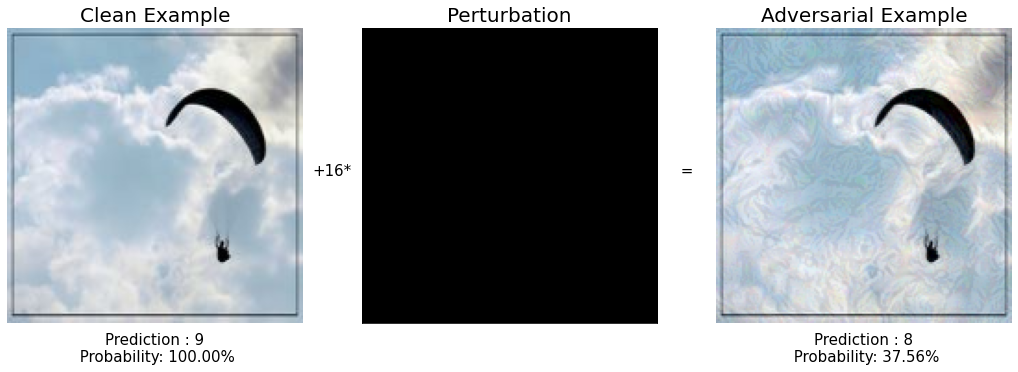

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


original_label : 8, adv_x_label : 2


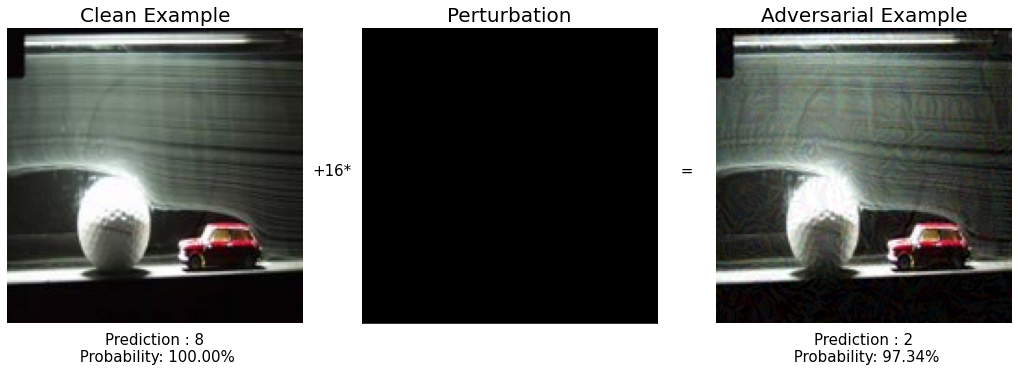

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


original_label : 7, adv_x_label : 6


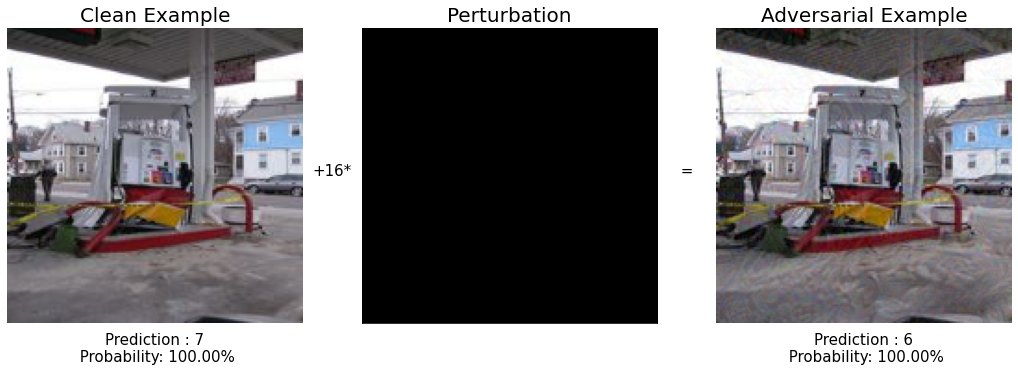

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


original_label : 1, adv_x_label : 8


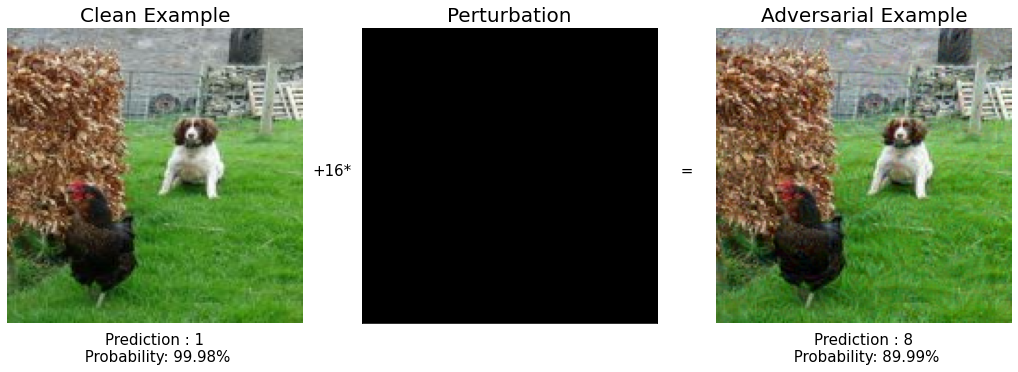

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


original_label : 4, adv_x_label : 6


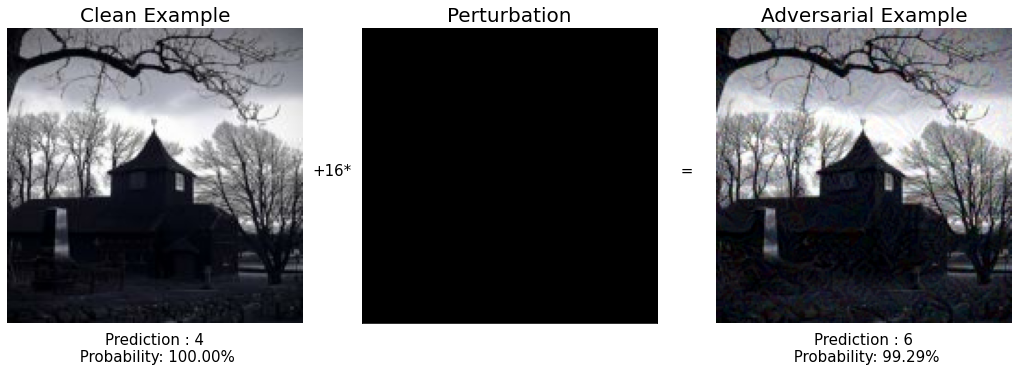

In [13]:
x_adv_images_100, x_adv_labels_100, labels, noise = select_adv_examples(y_test, x_adv_labels, x_adv_images, noise)

# 이미지를 svae하는 for문... 파이참에서는 실행이 되었지만, 쥬피터에서 실행이 안됨
# import imageio

# for i in range(gen_num):
#     save_path = f'data/adversarial_images/MI_FGSM_ENSEMBLE/attack2_{idx[i]}_{y_test[idx[i]]}.png'
#     imageio.imwrite(save_path, x_adv_images_100[i])

for i in range(5):
    display_image(X_test[idx[i]], x_adv_images_100[i], noise[i], eps)

### 여러 모델 공격 테스트
- Mobile Net
- Inception V3
- Resnet152

In [14]:
#  테스트

print('###Mobile NET###')
test_step(x_adv_images_100, labels, base_model)

print('###Inception v3###')
test_step(x_adv_images_100, labels, inception_v3_model)

print('###Inception v3 ens3###')
test_step(x_adv_images_100, labels, inception_v3_adv_model)

print('###Inception v3 adv ens3###')
test_step(x_adv_images_100, labels, inception_v3_adv_ens3_model)

print('###Inception v3 adv ens4###')
test_step(x_adv_images_100, labels, inception_v3_adv_ens4_model)

print('###Inception res adv###')
test_step(x_adv_images_100, labels, inception_res_adv_model)

print('###Inception res adv ens###')
test_step(x_adv_images_100, labels, inception_res_adv_ens_model)

print('###Resnet 152###')
test_step(x_adv_images_100, labels, resnet152_model)


###Mobile NET###
acc = 0.00%
loss = 10.3991
error_rate = 100.00%
###Inception v3###
acc = 25.33%
loss = 7.2210
error_rate = 74.67%
###Inception v3 ens3###
acc = 15.33%
loss = 6.6343
error_rate = 84.67%
###Inception v3 adv ens3###
acc = 43.33%
loss = 4.1131
error_rate = 56.67%
###Inception v3 adv ens4###
acc = 45.33%
loss = 4.4557
error_rate = 54.67%
###Inception res adv###
acc = 52.00%
loss = 4.1454
error_rate = 48.00%
###Inception res adv ens###
acc = 75.33%
loss = 2.0992
error_rate = 24.67%
###Resnet 152###
acc = 19.33%
loss = 6.7518
error_rate = 80.67%
